# Shortcut Maze with TDL and Q-Learning

<img src="shortcut_env.png" width="400">

In [1]:
import numpy as np
from agent import Agent
from environment import Environment
from rlglue import RLGlue
import time
from manager import Manager

In [2]:
class ShortcutMaze(Environment):
    def env_init(self, env_info={}):
        reward = None
        observation = None
        is_terminal = None
        self.reward_obs_term = (reward, observation, is_terminal)

        self.maze_dim = [env_info.get("grid_height", 6),
                         env_info.get("grid_width", 9)]

        self.start_state = (5, 3)
        self.end_state = (0, 8)
        self.obstacles = [(3,1),(3,2),(3,3),(3,4),(3,5),(3,6),(3,7),(3,8)]

    def env_start(self):
        reward = 0
        self.current_state = self.start_state
        state = self.env_state(self.current_state)
        is_terminal = False
        self.reward_obs_term = (reward, state, is_terminal)
        return self.reward_obs_term[1]

    def env_step(self, action):
        row = self.current_state[0]
        col = self.current_state[1]

        if action == 0:
            if not (self.env_out_of_bounds(row-1, col) or self.env_is_obstacle(row-1, col)):
                self.current_state = (row-1, col)

        elif action == 1:
            if not (self.env_out_of_bounds(row, col-1) or self.env_is_obstacle(row, col-1)):
                self.current_state = (row, col-1)

        elif action == 2:
            if not (self.env_out_of_bounds(row+1, col) or self.env_is_obstacle(row+1, col)):
                self.current_state = (row+1, col)

        elif action == 3:
            if not (self.env_out_of_bounds(row, col+1) or self.env_is_obstacle(row, col+1)):
                self.current_state = (row, col+1)

        reward = 0
        is_terminal = False

        if self.current_state == self.end_state:
            reward = 1
            is_terminal = True

        self.reward_obs_term = (reward, self.env_state(self.current_state), is_terminal)

        return self.reward_obs_term

    def env_cleanup(self):
        self.current_state = None

    def env_state(self, state):
        return state[0]*self.maze_dim[1] + state[1]

    def env_out_of_bounds(self, row, col):
        if row < 0 or row > self.maze_dim[0]-1 or col < 0 or col > self.maze_dim[1]-1:
            return True
        else:
            return False

    def env_is_obstacle(self, row, col):
        if (row, col) in self.obstacles:
            return True
        else:
            return False

In [3]:
class TDL(Agent):
    def agent_init(self, agent_info={}):
        self.discount = agent_info.get("discount")
        self.step_size = agent_info.get("step_size")
        self.policy = agent_info.get("policy")
        self.rand_generator = np.random.RandomState(agent_info.get('seed'))
        self.v = np.zeros((self.policy.shape[0],))

    def agent_start(self, state):
        action = self.agent_action(state)
        self.last_state = state
        return action

    def agent_step(self, reward, state):
        target = reward + self.discount*self.v[state]
        self.v[self.last_state] = self.v[self.last_state] + self.step_size*(target-self.v[self.last_state])

        action = self.agent_action(state)
        self.last_state = state
        return action

    def agent_end(self, reward):
        target = reward
        self.v[self.last_state] = self.v[self.last_state] + self.step_size*(target-self.v[self.last_state])

    def agent_cleanup(self):
        self.last_state = None

    def agent_action(self, state):
        return self.rand_generator.choice(range(self.policy.shape[1]), p=self.policy[state])

In [4]:
class PolicyEvaluation(RLGlue):
    def rl_run(self, env_info, agent_info, num_episodes, max_steps_this_episode, verbose=True):
        self.rl_init(agent_info, env_info)
        for episode in range(num_episodes):
            start_time = time.time()
            self.rl_episode(max_steps_this_episode)
            now = time.time()
            duration = now - start_time
            if verbose:
                print('Episode: {}/{} - Steps: {}'.format(episode+1, num_episodes, self.num_steps))
                print('----- {}s -----'.format(np.round(1000*duration)/1000))
        self.rl_cleanup()
        return self.agent.v

-----

In [5]:
env_info = {"grid_height": 6,
            "grid_width": 9}

shortcut_maze = ShortcutMaze()

In [6]:
zigzag_policy = np.ones(shape=(env_info['grid_width']*env_info['grid_height'], 4)) * 0.25
for i in range(5, 8):
    zigzag_policy[i] = [0, 0, 0, 1]
zigzag_policy[12] = [0, 0, 0, 1]
zigzag_policy[13] = [0, 0, 0, 1]
zigzag_policy[14] = [1, 0, 0, 0]
zigzag_policy[18] = [0, 0, 0, 1]
zigzag_policy[19] = [0, 0, 0, 1]
zigzag_policy[20] = [0, 0, 0, 1]
zigzag_policy[21] = [1, 0, 0, 0]
zigzag_policy[27] = [1, 0, 0, 0]
zigzag_policy[36] = [1, 0, 0, 0]
zigzag_policy[37] = [0, 1, 0, 0]
zigzag_policy[38] = [0, 1, 0, 0]
zigzag_policy[47] = [1, 0, 0, 0]
zigzag_policy[48] = [0, 1, 0, 0]

agent_info = {"discount": 0.95,
              "step_size": 0.01,
              "policy": zigzag_policy}

tdl = TDL()

In [7]:
num_episodes = 5000
max_steps_this_episode = float('inf')

policy_evaluation = PolicyEvaluation(env=shortcut_maze, agent=tdl)
v = policy_evaluation.rl_run(env_info=env_info,
                             agent_info=agent_info,
                             num_episodes=num_episodes,
                             max_steps_this_episode=max_steps_this_episode)

Episode: 1/5000 - Steps: 16
----- 0.002s -----
Episode: 2/5000 - Steps: 16
----- 0.001s -----
Episode: 3/5000 - Steps: 16
----- 0.001s -----
Episode: 4/5000 - Steps: 16
----- 0.002s -----
Episode: 5/5000 - Steps: 16
----- 0.001s -----
Episode: 6/5000 - Steps: 16
----- 0.001s -----
Episode: 7/5000 - Steps: 16
----- 0.001s -----
Episode: 8/5000 - Steps: 16
----- 0.001s -----
Episode: 9/5000 - Steps: 16
----- 0.001s -----
Episode: 10/5000 - Steps: 16
----- 0.0s -----
Episode: 11/5000 - Steps: 16
----- 0.001s -----
Episode: 12/5000 - Steps: 16
----- 0.0s -----
Episode: 13/5000 - Steps: 16
----- 0.0s -----
Episode: 14/5000 - Steps: 16
----- 0.001s -----
Episode: 15/5000 - Steps: 16
----- 0.0s -----
Episode: 16/5000 - Steps: 16
----- 0.0s -----
Episode: 17/5000 - Steps: 16
----- 0.0s -----
Episode: 18/5000 - Steps: 16
----- 0.0s -----
Episode: 19/5000 - Steps: 16
----- 0.0s -----
Episode: 20/5000 - Steps: 16
----- 0.001s -----
Episode: 21/5000 - Steps: 16
----- 0.0s -----
Episode: 22/5000 - 

Episode: 698/5000 - Steps: 16
----- 0.0s -----
Episode: 699/5000 - Steps: 16
----- 0.0s -----
Episode: 700/5000 - Steps: 16
----- 0.0s -----
Episode: 701/5000 - Steps: 16
----- 0.0s -----
Episode: 702/5000 - Steps: 16
----- 0.0s -----
Episode: 703/5000 - Steps: 16
----- 0.0s -----
Episode: 704/5000 - Steps: 16
----- 0.0s -----
Episode: 705/5000 - Steps: 16
----- 0.0s -----
Episode: 706/5000 - Steps: 16
----- 0.0s -----
Episode: 707/5000 - Steps: 16
----- 0.0s -----
Episode: 708/5000 - Steps: 16
----- 0.0s -----
Episode: 709/5000 - Steps: 16
----- 0.0s -----
Episode: 710/5000 - Steps: 16
----- 0.0s -----
Episode: 711/5000 - Steps: 16
----- 0.0s -----
Episode: 712/5000 - Steps: 16
----- 0.0s -----
Episode: 713/5000 - Steps: 16
----- 0.0s -----
Episode: 714/5000 - Steps: 16
----- 0.0s -----
Episode: 715/5000 - Steps: 16
----- 0.0s -----
Episode: 716/5000 - Steps: 16
----- 0.0s -----
Episode: 717/5000 - Steps: 16
----- 0.0s -----
Episode: 718/5000 - Steps: 16
----- 0.0s -----
Episode: 719/

Episode: 1224/5000 - Steps: 16
----- 0.0s -----
Episode: 1225/5000 - Steps: 16
----- 0.0s -----
Episode: 1226/5000 - Steps: 16
----- 0.0s -----
Episode: 1227/5000 - Steps: 16
----- 0.0s -----
Episode: 1228/5000 - Steps: 16
----- 0.0s -----
Episode: 1229/5000 - Steps: 16
----- 0.0s -----
Episode: 1230/5000 - Steps: 16
----- 0.0s -----
Episode: 1231/5000 - Steps: 16
----- 0.0s -----
Episode: 1232/5000 - Steps: 16
----- 0.0s -----
Episode: 1233/5000 - Steps: 16
----- 0.0s -----
Episode: 1234/5000 - Steps: 16
----- 0.0s -----
Episode: 1235/5000 - Steps: 16
----- 0.0s -----
Episode: 1236/5000 - Steps: 16
----- 0.0s -----
Episode: 1237/5000 - Steps: 16
----- 0.0s -----
Episode: 1238/5000 - Steps: 16
----- 0.0s -----
Episode: 1239/5000 - Steps: 16
----- 0.0s -----
Episode: 1240/5000 - Steps: 16
----- 0.0s -----
Episode: 1241/5000 - Steps: 16
----- 0.0s -----
Episode: 1242/5000 - Steps: 16
----- 0.0s -----
Episode: 1243/5000 - Steps: 16
----- 0.0s -----
Episode: 1244/5000 - Steps: 16
----- 0.0

Episode: 1870/5000 - Steps: 16
----- 0.0s -----
Episode: 1871/5000 - Steps: 16
----- 0.0s -----
Episode: 1872/5000 - Steps: 16
----- 0.0s -----
Episode: 1873/5000 - Steps: 16
----- 0.0s -----
Episode: 1874/5000 - Steps: 16
----- 0.0s -----
Episode: 1875/5000 - Steps: 16
----- 0.0s -----
Episode: 1876/5000 - Steps: 16
----- 0.0s -----
Episode: 1877/5000 - Steps: 16
----- 0.0s -----
Episode: 1878/5000 - Steps: 16
----- 0.0s -----
Episode: 1879/5000 - Steps: 16
----- 0.0s -----
Episode: 1880/5000 - Steps: 16
----- 0.0s -----
Episode: 1881/5000 - Steps: 16
----- 0.0s -----
Episode: 1882/5000 - Steps: 16
----- 0.0s -----
Episode: 1883/5000 - Steps: 16
----- 0.0s -----
Episode: 1884/5000 - Steps: 16
----- 0.0s -----
Episode: 1885/5000 - Steps: 16
----- 0.0s -----
Episode: 1886/5000 - Steps: 16
----- 0.0s -----
Episode: 1887/5000 - Steps: 16
----- 0.0s -----
Episode: 1888/5000 - Steps: 16
----- 0.0s -----
Episode: 1889/5000 - Steps: 16
----- 0.0s -----
Episode: 1890/5000 - Steps: 16
----- 0.0

----- 0.0s -----
Episode: 2474/5000 - Steps: 16
----- 0.0s -----
Episode: 2475/5000 - Steps: 16
----- 0.0s -----
Episode: 2476/5000 - Steps: 16
----- 0.0s -----
Episode: 2477/5000 - Steps: 16
----- 0.0s -----
Episode: 2478/5000 - Steps: 16
----- 0.0s -----
Episode: 2479/5000 - Steps: 16
----- 0.0s -----
Episode: 2480/5000 - Steps: 16
----- 0.0s -----
Episode: 2481/5000 - Steps: 16
----- 0.0s -----
Episode: 2482/5000 - Steps: 16
----- 0.0s -----
Episode: 2483/5000 - Steps: 16
----- 0.0s -----
Episode: 2484/5000 - Steps: 16
----- 0.0s -----
Episode: 2485/5000 - Steps: 16
----- 0.0s -----
Episode: 2486/5000 - Steps: 16
----- 0.0s -----
Episode: 2487/5000 - Steps: 16
----- 0.0s -----
Episode: 2488/5000 - Steps: 16
----- 0.0s -----
Episode: 2489/5000 - Steps: 16
----- 0.0s -----
Episode: 2490/5000 - Steps: 16
----- 0.0s -----
Episode: 2491/5000 - Steps: 16
----- 0.0s -----
Episode: 2492/5000 - Steps: 16
----- 0.0s -----
Episode: 2493/5000 - Steps: 16
----- 0.0s -----
Episode: 2494/5000 - St

Episode: 3162/5000 - Steps: 16
----- 0.0s -----
Episode: 3163/5000 - Steps: 16
----- 0.0s -----
Episode: 3164/5000 - Steps: 16
----- 0.0s -----
Episode: 3165/5000 - Steps: 16
----- 0.0s -----
Episode: 3166/5000 - Steps: 16
----- 0.0s -----
Episode: 3167/5000 - Steps: 16
----- 0.0s -----
Episode: 3168/5000 - Steps: 16
----- 0.0s -----
Episode: 3169/5000 - Steps: 16
----- 0.0s -----
Episode: 3170/5000 - Steps: 16
----- 0.0s -----
Episode: 3171/5000 - Steps: 16
----- 0.0s -----
Episode: 3172/5000 - Steps: 16
----- 0.0s -----
Episode: 3173/5000 - Steps: 16
----- 0.0s -----
Episode: 3174/5000 - Steps: 16
----- 0.0s -----
Episode: 3175/5000 - Steps: 16
----- 0.0s -----
Episode: 3176/5000 - Steps: 16
----- 0.0s -----
Episode: 3177/5000 - Steps: 16
----- 0.0s -----
Episode: 3178/5000 - Steps: 16
----- 0.0s -----
Episode: 3179/5000 - Steps: 16
----- 0.0s -----
Episode: 3180/5000 - Steps: 16
----- 0.0s -----
Episode: 3181/5000 - Steps: 16
----- 0.0s -----
Episode: 3182/5000 - Steps: 16
----- 0.0

Episode: 3737/5000 - Steps: 16
----- 0.0s -----
Episode: 3738/5000 - Steps: 16
----- 0.0s -----
Episode: 3739/5000 - Steps: 16
----- 0.0s -----
Episode: 3740/5000 - Steps: 16
----- 0.0s -----
Episode: 3741/5000 - Steps: 16
----- 0.0s -----
Episode: 3742/5000 - Steps: 16
----- 0.0s -----
Episode: 3743/5000 - Steps: 16
----- 0.0s -----
Episode: 3744/5000 - Steps: 16
----- 0.0s -----
Episode: 3745/5000 - Steps: 16
----- 0.0s -----
Episode: 3746/5000 - Steps: 16
----- 0.0s -----
Episode: 3747/5000 - Steps: 16
----- 0.0s -----
Episode: 3748/5000 - Steps: 16
----- 0.0s -----
Episode: 3749/5000 - Steps: 16
----- 0.0s -----
Episode: 3750/5000 - Steps: 16
----- 0.0s -----
Episode: 3751/5000 - Steps: 16
----- 0.0s -----
Episode: 3752/5000 - Steps: 16
----- 0.0s -----
Episode: 3753/5000 - Steps: 16
----- 0.0s -----
Episode: 3754/5000 - Steps: 16
----- 0.0s -----
Episode: 3755/5000 - Steps: 16
----- 0.0s -----
Episode: 3756/5000 - Steps: 16
----- 0.0s -----
Episode: 3757/5000 - Steps: 16
----- 0.0

Episode: 4446/5000 - Steps: 16
----- 0.0s -----
Episode: 4447/5000 - Steps: 16
----- 0.0s -----
Episode: 4448/5000 - Steps: 16
----- 0.0s -----
Episode: 4449/5000 - Steps: 16
----- 0.0s -----
Episode: 4450/5000 - Steps: 16
----- 0.0s -----
Episode: 4451/5000 - Steps: 16
----- 0.0s -----
Episode: 4452/5000 - Steps: 16
----- 0.0s -----
Episode: 4453/5000 - Steps: 16
----- 0.0s -----
Episode: 4454/5000 - Steps: 16
----- 0.0s -----
Episode: 4455/5000 - Steps: 16
----- 0.0s -----
Episode: 4456/5000 - Steps: 16
----- 0.0s -----
Episode: 4457/5000 - Steps: 16
----- 0.0s -----
Episode: 4458/5000 - Steps: 16
----- 0.0s -----
Episode: 4459/5000 - Steps: 16
----- 0.0s -----
Episode: 4460/5000 - Steps: 16
----- 0.0s -----
Episode: 4461/5000 - Steps: 16
----- 0.0s -----
Episode: 4462/5000 - Steps: 16
----- 0.0s -----
Episode: 4463/5000 - Steps: 16
----- 0.0s -----
Episode: 4464/5000 - Steps: 16
----- 0.0s -----
Episode: 4465/5000 - Steps: 16
----- 0.0s -----
Episode: 4466/5000 - Steps: 16
----- 0.0

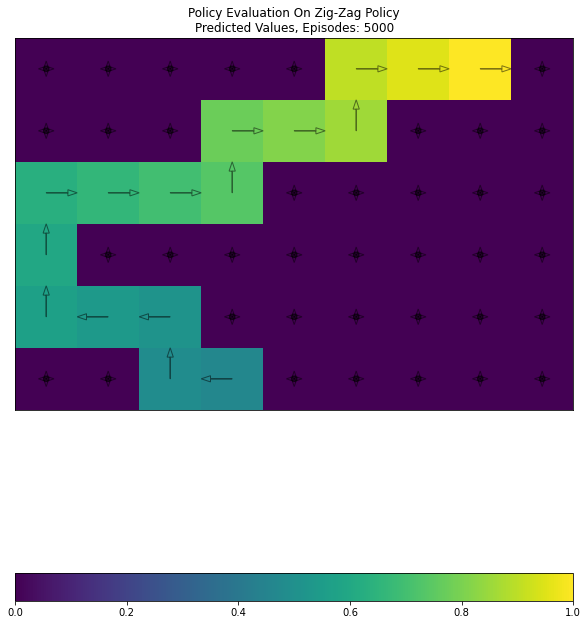

In [8]:
manager = Manager(env_info=env_info,
                  agent_info=agent_info,
                  experiment_name="Policy Evaluation On Zig-Zag Policy")
manager.visualize(values=v, num_episodes=num_episodes)

-----

In [9]:
class QLearning(Agent):
    def agent_init(self, agent_info={}):
        self.discount = agent_info.get("discount")
        self.step_size = agent_info.get("step_size")
        self.num_actions = agent_info.get("num_actions")
        self.num_states = agent_info.get("num_states")
        self.epsilon = agent_info.get("epsilon")
        self.decay_factor = agent_info.get("decay_factor")
        self.rand_generator = np.random.RandomState(agent_info.get("seed"))
        self.q = np.zeros((self.num_states, self.num_actions))
        self.policy = np.ones((self.num_states, self.num_actions))/self.num_actions

    def agent_start(self, state):
        action = self.agent_action(state)
        self.last_state = state
        self.last_action = action
        return action

    def agent_step(self, reward, state):
        action = self.agent_action(state)
        target = reward + self.discount*np.max(self.q[state, :])
        self.q[self.last_state, self.last_action] = self.q[self.last_state, self.last_action] + self.step_size*(target-self.q[self.last_state, self.last_action])

        self.agent_improvement(self.last_state)

        self.last_state = state
        self.last_action = action
        return action

    def agent_end(self, reward):
        target = reward
        self.q[self.last_state, self.last_action] = self.q[self.last_state, self.last_action] + self.step_size*(target-self.q[self.last_state, self.last_action])

    def agent_cleanup(self):
        self.last_state = None
        self.last_action = None

    def agent_action(self, state):
        return self.rand_generator.choice(range(self.policy.shape[1]), p=self.policy[state])

    def agent_improvement(self, state):
        self.epsilon = self.decay_factor*self.epsilon

        idx = self.agent_argmax(state)

        self.policy[state,:] = 0.
        self.policy[state,idx] = 1.
        p1 = self.epsilon/self.num_actions
        p2 = 1-(self.num_actions-1)*p1
        self.policy[state] = p1*(np.ones(self.num_actions)-self.policy[state]) + p2*self.policy[state]

    def agent_argmax(self, state):
        q_max = np.max(self.q[state,:])
        y = 1-np.square(np.sign(self.q[state,:]-q_max))
        y = y/np.sum(y)
        return self.rand_generator.choice(self.num_actions, p=y)

In [10]:
class PolicyIteration(RLGlue):
    def rl_run(self, env_info, agent_info, num_episodes, max_steps_this_episode, verbose=True):
        self.rl_init(agent_info, env_info)
        for episode in range(num_episodes):
            start_time = time.time()
            self.rl_episode(max_steps_this_episode)
            now = time.time()
            duration = now - start_time
            if verbose:
                print('Episode: {}/{} - Steps: {} - Epsilon: {}'.format(episode+1, num_episodes, self.num_steps, self.agent.epsilon))
                print('----- {}s -----'.format(np.round(1000*duration)/1000))

        #for state in range(self.agent.num_states):
        #    self.agent.epsilon = 0.
        #    self.agent.agent_improvement(state)

        self.rl_cleanup()
        return self.agent.policy

-----

In [11]:
agent_info = {"discount": 0.95,
              "step_size": 0.5,
              "num_states": env_info['grid_width']*env_info['grid_height'],
              "num_actions": 4,
              "epsilon": 0.9,
              "decay_factor": 0.9999}

q_learning = QLearning()

In [12]:
num_episodes = 5000
max_steps_this_episode = float('inf')

policy_iteration = PolicyIteration(env=shortcut_maze, agent=q_learning)
optimal_policy = policy_iteration.rl_run(env_info=env_info,
                                         agent_info=agent_info,
                                         num_episodes=num_episodes,
                                         max_steps_this_episode=max_steps_this_episode)

Episode: 1/5000 - Steps: 932 - Epsilon: 0.8199883296426919
----- 0.07s -----
Episode: 2/5000 - Steps: 829 - Epsilon: 0.7548250252378796
----- 0.031s -----
Episode: 3/5000 - Steps: 748 - Epsilon: 0.7004915006832342
----- 0.025s -----
Episode: 4/5000 - Steps: 739 - Epsilon: 0.6506543457189822
----- 0.025s -----
Episode: 5/5000 - Steps: 200 - Epsilon: 0.6378336720094947
----- 0.007s -----
Episode: 6/5000 - Steps: 1178 - Epsilon: 0.5670070070613275
----- 0.04s -----
Episode: 7/5000 - Steps: 118 - Epsilon: 0.5604113550980905
----- 0.004s -----
Episode: 8/5000 - Steps: 745 - Epsilon: 0.5202280933702523
----- 0.025s -----
Episode: 9/5000 - Steps: 420 - Epsilon: 0.4988798381075517
----- 0.014s -----
Episode: 10/5000 - Steps: 317 - Epsilon: 0.483360949133326
----- 0.011s -----
Episode: 11/5000 - Steps: 94 - Epsilon: 0.47888630790485104
----- 0.003s -----
Episode: 12/5000 - Steps: 41 - Epsilon: 0.4769744932594103
----- 0.001s -----
Episode: 13/5000 - Steps: 23 - Epsilon: 0.47592625045112713
----

Episode: 246/5000 - Steps: 17 - Epsilon: 0.25511941486262385
----- 0.001s -----
Episode: 247/5000 - Steps: 25 - Epsilon: 0.25450783188044807
----- 0.001s -----
Episode: 248/5000 - Steps: 18 - Epsilon: 0.25407551452389787
----- 0.001s -----
Episode: 249/5000 - Steps: 31 - Epsilon: 0.25331439217796364
----- 0.001s -----
Episode: 250/5000 - Steps: 19 - Epsilon: 0.25285881363643636
----- 0.001s -----
Episode: 251/5000 - Steps: 16 - Epsilon: 0.2524797908027199
----- 0.001s -----
Episode: 252/5000 - Steps: 17 - Epsilon: 0.25207612597184176
----- 0.001s -----
Episode: 253/5000 - Steps: 24 - Epsilon: 0.2514969881885016
----- 0.001s -----
Episode: 254/5000 - Steps: 17 - Epsilon: 0.25109489466299345
----- 0.001s -----
Episode: 255/5000 - Steps: 31 - Epsilon: 0.25034270122303864
----- 0.001s -----
Episode: 256/5000 - Steps: 24 - Epsilon: 0.24976754593412448
----- 0.001s -----
Episode: 257/5000 - Steps: 29 - Epsilon: 0.24906914010910533
----- 0.001s -----
Episode: 258/5000 - Steps: 21 - Epsilon: 0

Episode: 502/5000 - Steps: 19 - Epsilon: 0.15390052581449257
----- 0.001s -----
Episode: 503/5000 - Steps: 19 - Epsilon: 0.1536237402102953
----- 0.001s -----
Episode: 504/5000 - Steps: 16 - Epsilon: 0.1533934658350293
----- 0.001s -----
Episode: 505/5000 - Steps: 17 - Epsilon: 0.15314822027597985
----- 0.001s -----
Episode: 506/5000 - Steps: 20 - Epsilon: 0.15285750039257093
----- 0.001s -----
Episode: 507/5000 - Steps: 16 - Epsilon: 0.15262837457282818
----- 0.001s -----
Episode: 508/5000 - Steps: 21 - Epsilon: 0.15232340764367183
----- 0.001s -----
Episode: 509/5000 - Steps: 22 - Epsilon: 0.15200384816427723
----- 0.001s -----
Episode: 510/5000 - Steps: 23 - Epsilon: 0.15166979059323044
----- 0.001s -----
Episode: 511/5000 - Steps: 18 - Epsilon: 0.15141215811703782
----- 0.001s -----
Episode: 512/5000 - Steps: 18 - Epsilon: 0.1511549632658497
----- 0.001s -----
Episode: 513/5000 - Steps: 20 - Epsilon: 0.15086802716422124
----- 0.001s -----
Episode: 514/5000 - Steps: 37 - Epsilon: 0.

Episode: 767/5000 - Steps: 17 - Epsilon: 0.09672609641337247
----- 0.001s -----
Episode: 768/5000 - Steps: 19 - Epsilon: 0.09655213735185701
----- 0.001s -----
Episode: 769/5000 - Steps: 16 - Epsilon: 0.09640741048165544
----- 0.001s -----
Episode: 770/5000 - Steps: 16 - Epsilon: 0.09626290054986178
----- 0.001s -----
Episode: 771/5000 - Steps: 16 - Epsilon: 0.0961186072312961
----- 0.001s -----
Episode: 772/5000 - Steps: 19 - Epsilon: 0.09594574072134548
----- 0.001s -----
Episode: 773/5000 - Steps: 20 - Epsilon: 0.09576360778825733
----- 0.001s -----
Episode: 774/5000 - Steps: 17 - Epsilon: 0.09561050087851529
----- 0.001s -----
Episode: 775/5000 - Steps: 18 - Epsilon: 0.09544809299231065
----- 0.001s -----
Episode: 776/5000 - Steps: 16 - Epsilon: 0.09530502102990399
----- 0.001s -----
Episode: 777/5000 - Steps: 16 - Epsilon: 0.09516216352528042
----- 0.001s -----
Episode: 778/5000 - Steps: 20 - Epsilon: 0.09498151804970675
----- 0.001s -----
Episode: 779/5000 - Steps: 19 - Epsilon: 

Episode: 1064/5000 - Steps: 16 - Epsilon: 0.05955254215272519
----- 0.001s -----
Episode: 1065/5000 - Steps: 17 - Epsilon: 0.05945732951499284
----- 0.001s -----
Episode: 1066/5000 - Steps: 16 - Epsilon: 0.059368205923871376
----- 0.001s -----
Episode: 1067/5000 - Steps: 18 - Epsilon: 0.05926736067420461
----- 0.001s -----
Episode: 1068/5000 - Steps: 18 - Epsilon: 0.05916668672438131
----- 0.001s -----
Episode: 1069/5000 - Steps: 17 - Epsilon: 0.0590720909925238
----- 0.001s -----
Episode: 1070/5000 - Steps: 18 - Epsilon: 0.0589717487357253
----- 0.001s -----
Episode: 1071/5000 - Steps: 16 - Epsilon: 0.05888335300613379
----- 0.001s -----
Episode: 1072/5000 - Steps: 17 - Epsilon: 0.05878921026838362
----- 0.001s -----
Episode: 1073/5000 - Steps: 17 - Epsilon: 0.05869521804609528
----- 0.001s -----
Episode: 1074/5000 - Steps: 18 - Epsilon: 0.05859551596101468
----- 0.001s -----
Episode: 1075/5000 - Steps: 18 - Epsilon: 0.058495983233951665
----- 0.001s -----
Episode: 1076/5000 - Steps: 

Episode: 1363/5000 - Steps: 16 - Epsilon: 0.03708584285911377
----- 0.001s -----
Episode: 1364/5000 - Steps: 18 - Epsilon: 0.03702284733779002
----- 0.001s -----
Episode: 1365/5000 - Steps: 16 - Epsilon: 0.036967351923932704
----- 0.001s -----
Episode: 1366/5000 - Steps: 16 - Epsilon: 0.03691193969495122
----- 0.001s -----
Episode: 1367/5000 - Steps: 16 - Epsilon: 0.036856610526155596
----- 0.001s -----
Episode: 1368/5000 - Steps: 18 - Epsilon: 0.036794004388197736
----- 0.001s -----
Episode: 1369/5000 - Steps: 16 - Epsilon: 0.03673885199858381
----- 0.001s -----
Episode: 1370/5000 - Steps: 18 - Epsilon: 0.03667644589005124
----- 0.001s -----
Episode: 1371/5000 - Steps: 16 - Epsilon: 0.03662146971480158
----- 0.001s -----
Episode: 1372/5000 - Steps: 16 - Epsilon: 0.036566575946114815
----- 0.001s -----
Episode: 1373/5000 - Steps: 16 - Epsilon: 0.036511764460467576
----- 0.001s -----
Episode: 1374/5000 - Steps: 16 - Epsilon: 0.0364570351345217
----- 0.001s -----
Episode: 1375/5000 - Ste

Episode: 1669/5000 - Steps: 17 - Epsilon: 0.02299349617867219
----- 0.001s -----
Episode: 1670/5000 - Steps: 16 - Epsilon: 0.022959030067116273
----- 0.001s -----
Episode: 1671/5000 - Steps: 16 - Epsilon: 0.022924615618553947
----- 0.001s -----
Episode: 1672/5000 - Steps: 16 - Epsilon: 0.02289025275554495
----- 0.001s -----
Episode: 1673/5000 - Steps: 16 - Epsilon: 0.022855941400765085
----- 0.001s -----
Episode: 1674/5000 - Steps: 16 - Epsilon: 0.022821681477006084
----- 0.001s -----
Episode: 1675/5000 - Steps: 16 - Epsilon: 0.02278747290717538
----- 0.001s -----
Episode: 1676/5000 - Steps: 16 - Epsilon: 0.022753315614295985
----- 0.001s -----
Episode: 1677/5000 - Steps: 16 - Epsilon: 0.022719209521506294
----- 0.001s -----
Episode: 1678/5000 - Steps: 16 - Epsilon: 0.02268515455205989
----- 0.001s -----
Episode: 1679/5000 - Steps: 16 - Epsilon: 0.022651150629325437
----- 0.001s -----
Episode: 1680/5000 - Steps: 16 - Epsilon: 0.022617197676786435
----- 0.001s -----
Episode: 1681/5000 -

Episode: 1960/5000 - Steps: 16 - Epsilon: 0.01471237644532158
----- 0.001s -----
Episode: 1961/5000 - Steps: 16 - Epsilon: 0.014690323321956742
----- 0.001s -----
Episode: 1962/5000 - Steps: 16 - Epsilon: 0.014668303255131207
----- 0.001s -----
Episode: 1963/5000 - Steps: 16 - Epsilon: 0.014646316195294851
----- 0.001s -----
Episode: 1964/5000 - Steps: 16 - Epsilon: 0.014624362092971839
----- 0.001s -----
Episode: 1965/5000 - Steps: 16 - Epsilon: 0.014602440898760496
----- 0.001s -----
Episode: 1966/5000 - Steps: 16 - Epsilon: 0.014580552563333182
----- 0.001s -----
Episode: 1967/5000 - Steps: 16 - Epsilon: 0.014558697037436211
----- 0.001s -----
Episode: 1968/5000 - Steps: 16 - Epsilon: 0.014536874271889726
----- 0.001s -----
Episode: 1969/5000 - Steps: 16 - Epsilon: 0.014515084217587584
----- 0.001s -----
Episode: 1970/5000 - Steps: 17 - Epsilon: 0.0144918774928147
----- 0.001s -----
Episode: 1971/5000 - Steps: 16 - Epsilon: 0.01447015488645502
----- 0.001s -----
Episode: 1972/5000 -

Episode: 2302/5000 - Steps: 16 - Epsilon: 0.008760589111724733
----- 0.001s -----
Episode: 2303/5000 - Steps: 16 - Epsilon: 0.008747457422690839
----- 0.001s -----
Episode: 2304/5000 - Steps: 16 - Epsilon: 0.008734345417408198
----- 0.001s -----
Episode: 2305/5000 - Steps: 16 - Epsilon: 0.00872125306637184
----- 0.001s -----
Episode: 2306/5000 - Steps: 17 - Epsilon: 0.008707309522087012
----- 0.001s -----
Episode: 2307/5000 - Steps: 16 - Epsilon: 0.008694257696518243
----- 0.001s -----
Episode: 2308/5000 - Steps: 16 - Epsilon: 0.008681225434989346
----- 0.001s -----
Episode: 2309/5000 - Steps: 16 - Epsilon: 0.008668212708174798
----- 0.001s -----
Episode: 2310/5000 - Steps: 16 - Epsilon: 0.008655219486793025
----- 0.001s -----
Episode: 2311/5000 - Steps: 16 - Epsilon: 0.008642245741606354
----- 0.001s -----
Episode: 2312/5000 - Steps: 16 - Epsilon: 0.008629291443420931
----- 0.001s -----
Episode: 2313/5000 - Steps: 16 - Epsilon: 0.008616356563086664
----- 0.001s -----
Episode: 2314/500

Episode: 2638/5000 - Steps: 16 - Epsilon: 0.00527636704477062
----- 0.001s -----
Episode: 2639/5000 - Steps: 16 - Epsilon: 0.005268458031988835
----- 0.001s -----
Episode: 2640/5000 - Steps: 16 - Epsilon: 0.005260560874425356
----- 0.001s -----
Episode: 2641/5000 - Steps: 18 - Epsilon: 0.0052516250717256924
----- 0.001s -----
Episode: 2642/5000 - Steps: 16 - Epsilon: 0.005243753145935656
----- 0.001s -----
Episode: 2643/5000 - Steps: 16 - Epsilon: 0.005235893019772365
----- 0.001s -----
Episode: 2644/5000 - Steps: 16 - Epsilon: 0.005228044675548762
----- 0.001s -----
Episode: 2645/5000 - Steps: 16 - Epsilon: 0.005220208095604304
----- 0.001s -----
Episode: 2646/5000 - Steps: 16 - Epsilon: 0.005212383262304917
----- 0.001s -----
Episode: 2647/5000 - Steps: 16 - Epsilon: 0.005204570158042962
----- 0.001s -----
Episode: 2648/5000 - Steps: 16 - Epsilon: 0.005196768765237195
----- 0.001s -----
Episode: 2649/5000 - Steps: 16 - Epsilon: 0.005188979066332723
----- 0.001s -----
Episode: 2650/50

Episode: 2959/5000 - Steps: 16 - Epsilon: 0.0032518159676818152
----- 0.001s -----
Episode: 2960/5000 - Steps: 16 - Epsilon: 0.0032469416566579265
----- 0.001s -----
Episode: 2961/5000 - Steps: 16 - Epsilon: 0.0032420746519847637
----- 0.001s -----
Episode: 2962/5000 - Steps: 16 - Epsilon: 0.00323721494271047
----- 0.001s -----
Episode: 2963/5000 - Steps: 16 - Epsilon: 0.003232362517899604
----- 0.001s -----
Episode: 2964/5000 - Steps: 16 - Epsilon: 0.0032275173666331154
----- 0.001s -----
Episode: 2965/5000 - Steps: 16 - Epsilon: 0.0032226794780083204
----- 0.001s -----
Episode: 2966/5000 - Steps: 16 - Epsilon: 0.0032178488411388814
----- 0.001s -----
Episode: 2967/5000 - Steps: 16 - Epsilon: 0.003213025445154774
----- 0.001s -----
Episode: 2968/5000 - Steps: 16 - Epsilon: 0.0032082092792022716
----- 0.001s -----
Episode: 2969/5000 - Steps: 16 - Epsilon: 0.0032034003324439148
----- 0.001s -----
Episode: 2970/5000 - Steps: 16 - Epsilon: 0.003198598594058488
----- 0.001s -----
Episode: 

Episode: 3264/5000 - Steps: 16 - Epsilon: 0.002056058248249899
----- 0.001s -----
Episode: 3265/5000 - Steps: 16 - Epsilon: 0.002052976318803459
----- 0.001s -----
Episode: 3266/5000 - Steps: 16 - Epsilon: 0.002049899009016565
----- 0.001s -----
Episode: 3267/5000 - Steps: 16 - Epsilon: 0.002046826311964576
----- 0.001s -----
Episode: 3268/5000 - Steps: 16 - Epsilon: 0.00204375822073323
----- 0.001s -----
Episode: 3269/5000 - Steps: 16 - Epsilon: 0.002040694728418632
----- 0.001s -----
Episode: 3270/5000 - Steps: 18 - Epsilon: 0.0020372283213379644
----- 0.001s -----
Episode: 3271/5000 - Steps: 16 - Epsilon: 0.0020341746170190345
----- 0.001s -----
Episode: 3272/5000 - Steps: 16 - Epsilon: 0.002031125490051582
----- 0.001s -----
Episode: 3273/5000 - Steps: 16 - Epsilon: 0.002028080933574385
----- 0.001s -----
Episode: 3274/5000 - Steps: 16 - Epsilon: 0.0020250409407365035
----- 0.001s -----
Episode: 3275/5000 - Steps: 16 - Epsilon: 0.002022005504697269
----- 0.001s -----
Episode: 3276/

Episode: 3573/5000 - Steps: 16 - Epsilon: 0.001292098255353511
----- 0.001s -----
Episode: 3574/5000 - Steps: 16 - Epsilon: 0.0012901614640859207
----- 0.001s -----
Episode: 3575/5000 - Steps: 20 - Epsilon: 0.0012877123622305946
----- 0.001s -----
Episode: 3576/5000 - Steps: 16 - Epsilon: 0.0012857821451994957
----- 0.001s -----
Episode: 3577/5000 - Steps: 16 - Epsilon: 0.0012838548214680933
----- 0.001s -----
Episode: 3578/5000 - Steps: 16 - Epsilon: 0.0012819303866994753
----- 0.001s -----
Episode: 3579/5000 - Steps: 16 - Epsilon: 0.001280008836563229
----- 0.001s -----
Episode: 3580/5000 - Steps: 16 - Epsilon: 0.001278090166735433
----- 0.001s -----
Episode: 3581/5000 - Steps: 16 - Epsilon: 0.0012761743728986485
----- 0.001s -----
Episode: 3582/5000 - Steps: 16 - Epsilon: 0.0012742614507419074
----- 0.001s -----
Episode: 3583/5000 - Steps: 16 - Epsilon: 0.001272351395960703
----- 0.001s -----
Episode: 3584/5000 - Steps: 16 - Epsilon: 0.001270444204256981
----- 0.001s -----
Episode: 

Episode: 3873/5000 - Steps: 16 - Epsilon: 0.0008233654917395617
----- 0.001s -----
Episode: 3874/5000 - Steps: 16 - Epsilon: 0.0008221313076612
----- 0.001s -----
Episode: 3875/5000 - Steps: 16 - Epsilon: 0.0008208989735636241
----- 0.001s -----
Episode: 3876/5000 - Steps: 16 - Epsilon: 0.0008196684866738041
----- 0.001s -----
Episode: 3877/5000 - Steps: 16 - Epsilon: 0.0008184398442228673
----- 0.001s -----
Episode: 3878/5000 - Steps: 16 - Epsilon: 0.0008172130434460911
----- 0.001s -----
Episode: 3879/5000 - Steps: 16 - Epsilon: 0.0008159880815828974
----- 0.001s -----
Episode: 3880/5000 - Steps: 16 - Epsilon: 0.0008147649558768455
----- 0.001s -----
Episode: 3881/5000 - Steps: 16 - Epsilon: 0.0008135436635756271
----- 0.001s -----
Episode: 3882/5000 - Steps: 16 - Epsilon: 0.0008123242019310592
----- 0.001s -----
Episode: 3883/5000 - Steps: 16 - Epsilon: 0.0008111065681990779
----- 0.001s -----
Episode: 3884/5000 - Steps: 16 - Epsilon: 0.0008098907596397335
----- 0.001s -----
Episode

Episode: 4178/5000 - Steps: 16 - Epsilon: 0.0005210663174680464
----- 0.001s -----
Episode: 4179/5000 - Steps: 16 - Epsilon: 0.0005202852648744636
----- 0.001s -----
Episode: 4180/5000 - Steps: 16 - Epsilon: 0.0005195053830400214
----- 0.001s -----
Episode: 4181/5000 - Steps: 16 - Epsilon: 0.0005187266702098094
----- 0.001s -----
Episode: 4182/5000 - Steps: 16 - Epsilon: 0.0005179491246315488
----- 0.001s -----
Episode: 4183/5000 - Steps: 16 - Epsilon: 0.0005171727445555861
----- 0.001s -----
Episode: 4184/5000 - Steps: 16 - Epsilon: 0.0005163975282348916
----- 0.001s -----
Episode: 4185/5000 - Steps: 16 - Epsilon: 0.0005156234739250536
----- 0.001s -----
Episode: 4186/5000 - Steps: 16 - Epsilon: 0.0005148505798842753
----- 0.001s -----
Episode: 4187/5000 - Steps: 16 - Epsilon: 0.000514078844373371
----- 0.001s -----
Episode: 4188/5000 - Steps: 16 - Epsilon: 0.000513308265655762
----- 0.001s -----
Episode: 4189/5000 - Steps: 16 - Epsilon: 0.0005125388419974722
----- 0.001s -----
Episod

Episode: 4487/5000 - Steps: 16 - Epsilon: 0.0003277182141405114
----- 0.001s -----
Episode: 4488/5000 - Steps: 16 - Epsilon: 0.00032722698077435855
----- 0.001s -----
Episode: 4489/5000 - Steps: 16 - Epsilon: 0.00032673648374268317
----- 0.001s -----
Episode: 4490/5000 - Steps: 16 - Epsilon: 0.0003262467219417567
----- 0.001s -----
Episode: 4491/5000 - Steps: 16 - Epsilon: 0.00032575769426950444
----- 0.001s -----
Episode: 4492/5000 - Steps: 16 - Epsilon: 0.000325269399625504
----- 0.001s -----
Episode: 4493/5000 - Steps: 16 - Epsilon: 0.00032478183691098225
----- 0.001s -----
Episode: 4494/5000 - Steps: 16 - Epsilon: 0.00032429500502881314
----- 0.001s -----
Episode: 4495/5000 - Steps: 16 - Epsilon: 0.00032380890288351527
----- 0.001s -----
Episode: 4496/5000 - Steps: 16 - Epsilon: 0.0003233235293812492
----- 0.001s -----
Episode: 4497/5000 - Steps: 16 - Epsilon: 0.00032283888342981513
----- 0.001s -----
Episode: 4498/5000 - Steps: 16 - Epsilon: 0.00032235496393865043
----- 0.001s ---

----- 0.001s -----
Episode: 4825/5000 - Steps: 16 - Epsilon: 0.00019737960119004433
----- 0.001s -----
Episode: 4826/5000 - Steps: 16 - Epsilon: 0.00019708373894705973
----- 0.001s -----
Episode: 4827/5000 - Steps: 16 - Epsilon: 0.00019678832018691888
----- 0.001s -----
Episode: 4828/5000 - Steps: 16 - Epsilon: 0.00019649334424486284
----- 0.001s -----
Episode: 4829/5000 - Steps: 16 - Epsilon: 0.00019619881045712938
----- 0.001s -----
Episode: 4830/5000 - Steps: 16 - Epsilon: 0.00019590471816095098
----- 0.001s -----
Episode: 4831/5000 - Steps: 16 - Epsilon: 0.0001956110666945538
----- 0.001s -----
Episode: 4832/5000 - Steps: 16 - Epsilon: 0.00019531785539715564
----- 0.001s -----
Episode: 4833/5000 - Steps: 16 - Epsilon: 0.0001950250836089651
----- 0.001s -----
Episode: 4834/5000 - Steps: 16 - Epsilon: 0.0001947327506711797
----- 0.001s -----
Episode: 4835/5000 - Steps: 16 - Epsilon: 0.00019444085592598432
----- 0.001s -----
Episode: 4836/5000 - Steps: 16 - Epsilon: 0.0001941493987165

In [13]:
agent_info = {"discount": 0.95,
              "step_size": 0.01,
              "policy": optimal_policy}

tdl = TDL()

In [14]:
num_episodes = 5000
max_steps_this_episode = float('inf')

policy_evaluation = PolicyEvaluation(env=shortcut_maze, agent=tdl)
v = policy_evaluation.rl_run(env_info=env_info,
                             agent_info=agent_info,
                             num_episodes=num_episodes,
                             max_steps_this_episode=max_steps_this_episode)

Episode: 1/5000 - Steps: 16
----- 0.002s -----
Episode: 2/5000 - Steps: 16
----- 0.001s -----
Episode: 3/5000 - Steps: 16
----- 0.0s -----
Episode: 4/5000 - Steps: 16
----- 0.0s -----
Episode: 5/5000 - Steps: 16
----- 0.0s -----
Episode: 6/5000 - Steps: 16
----- 0.0s -----
Episode: 7/5000 - Steps: 16
----- 0.0s -----
Episode: 8/5000 - Steps: 16
----- 0.0s -----
Episode: 9/5000 - Steps: 16
----- 0.0s -----
Episode: 10/5000 - Steps: 16
----- 0.0s -----
Episode: 11/5000 - Steps: 16
----- 0.0s -----
Episode: 12/5000 - Steps: 16
----- 0.0s -----
Episode: 13/5000 - Steps: 16
----- 0.0s -----
Episode: 14/5000 - Steps: 16
----- 0.0s -----
Episode: 15/5000 - Steps: 16
----- 0.0s -----
Episode: 16/5000 - Steps: 16
----- 0.0s -----
Episode: 17/5000 - Steps: 16
----- 0.0s -----
Episode: 18/5000 - Steps: 16
----- 0.0s -----
Episode: 19/5000 - Steps: 16
----- 0.0s -----
Episode: 20/5000 - Steps: 16
----- 0.0s -----
Episode: 21/5000 - Steps: 16
----- 0.0s -----
Episode: 22/5000 - Steps: 16
----- 0.0s

----- 0.0s -----
Episode: 291/5000 - Steps: 16
----- 0.0s -----
Episode: 292/5000 - Steps: 16
----- 0.0s -----
Episode: 293/5000 - Steps: 16
----- 0.0s -----
Episode: 294/5000 - Steps: 16
----- 0.0s -----
Episode: 295/5000 - Steps: 16
----- 0.0s -----
Episode: 296/5000 - Steps: 16
----- 0.0s -----
Episode: 297/5000 - Steps: 16
----- 0.0s -----
Episode: 298/5000 - Steps: 16
----- 0.0s -----
Episode: 299/5000 - Steps: 16
----- 0.0s -----
Episode: 300/5000 - Steps: 16
----- 0.0s -----
Episode: 301/5000 - Steps: 16
----- 0.0s -----
Episode: 302/5000 - Steps: 16
----- 0.0s -----
Episode: 303/5000 - Steps: 16
----- 0.0s -----
Episode: 304/5000 - Steps: 16
----- 0.0s -----
Episode: 305/5000 - Steps: 16
----- 0.0s -----
Episode: 306/5000 - Steps: 16
----- 0.0s -----
Episode: 307/5000 - Steps: 16
----- 0.0s -----
Episode: 308/5000 - Steps: 16
----- 0.0s -----
Episode: 309/5000 - Steps: 16
----- 0.0s -----
Episode: 310/5000 - Steps: 16
----- 0.0s -----
Episode: 311/5000 - Steps: 16
----- 0.0s --

Episode: 688/5000 - Steps: 16
----- 0.0s -----
Episode: 689/5000 - Steps: 16
----- 0.0s -----
Episode: 690/5000 - Steps: 16
----- 0.0s -----
Episode: 691/5000 - Steps: 16
----- 0.0s -----
Episode: 692/5000 - Steps: 16
----- 0.0s -----
Episode: 693/5000 - Steps: 16
----- 0.0s -----
Episode: 694/5000 - Steps: 16
----- 0.0s -----
Episode: 695/5000 - Steps: 16
----- 0.0s -----
Episode: 696/5000 - Steps: 16
----- 0.0s -----
Episode: 697/5000 - Steps: 16
----- 0.0s -----
Episode: 698/5000 - Steps: 16
----- 0.0s -----
Episode: 699/5000 - Steps: 16
----- 0.001s -----
Episode: 700/5000 - Steps: 16
----- 0.0s -----
Episode: 701/5000 - Steps: 16
----- 0.0s -----
Episode: 702/5000 - Steps: 16
----- 0.0s -----
Episode: 703/5000 - Steps: 16
----- 0.0s -----
Episode: 704/5000 - Steps: 16
----- 0.0s -----
Episode: 705/5000 - Steps: 16
----- 0.0s -----
Episode: 706/5000 - Steps: 16
----- 0.0s -----
Episode: 707/5000 - Steps: 16
----- 0.0s -----
Episode: 708/5000 - Steps: 16
----- 0.0s -----
Episode: 70

----- 0.0s -----
Episode: 947/5000 - Steps: 16
----- 0.0s -----
Episode: 948/5000 - Steps: 16
----- 0.0s -----
Episode: 949/5000 - Steps: 16
----- 0.0s -----
Episode: 950/5000 - Steps: 16
----- 0.0s -----
Episode: 951/5000 - Steps: 16
----- 0.0s -----
Episode: 952/5000 - Steps: 16
----- 0.0s -----
Episode: 953/5000 - Steps: 16
----- 0.0s -----
Episode: 954/5000 - Steps: 16
----- 0.0s -----
Episode: 955/5000 - Steps: 16
----- 0.0s -----
Episode: 956/5000 - Steps: 16
----- 0.0s -----
Episode: 957/5000 - Steps: 16
----- 0.0s -----
Episode: 958/5000 - Steps: 16
----- 0.0s -----
Episode: 959/5000 - Steps: 16
----- 0.0s -----
Episode: 960/5000 - Steps: 16
----- 0.0s -----
Episode: 961/5000 - Steps: 16
----- 0.0s -----
Episode: 962/5000 - Steps: 16
----- 0.0s -----
Episode: 963/5000 - Steps: 16
----- 0.0s -----
Episode: 964/5000 - Steps: 16
----- 0.0s -----
Episode: 965/5000 - Steps: 16
----- 0.0s -----
Episode: 966/5000 - Steps: 16
----- 0.0s -----
Episode: 967/5000 - Steps: 16
----- 0.0s --

Episode: 1254/5000 - Steps: 16
----- 0.001s -----
Episode: 1255/5000 - Steps: 16
----- 0.0s -----
Episode: 1256/5000 - Steps: 16
----- 0.0s -----
Episode: 1257/5000 - Steps: 16
----- 0.0s -----
Episode: 1258/5000 - Steps: 16
----- 0.0s -----
Episode: 1259/5000 - Steps: 16
----- 0.0s -----
Episode: 1260/5000 - Steps: 16
----- 0.0s -----
Episode: 1261/5000 - Steps: 16
----- 0.0s -----
Episode: 1262/5000 - Steps: 16
----- 0.0s -----
Episode: 1263/5000 - Steps: 16
----- 0.0s -----
Episode: 1264/5000 - Steps: 16
----- 0.0s -----
Episode: 1265/5000 - Steps: 16
----- 0.0s -----
Episode: 1266/5000 - Steps: 16
----- 0.0s -----
Episode: 1267/5000 - Steps: 16
----- 0.0s -----
Episode: 1268/5000 - Steps: 16
----- 0.0s -----
Episode: 1269/5000 - Steps: 16
----- 0.0s -----
Episode: 1270/5000 - Steps: 16
----- 0.0s -----
Episode: 1271/5000 - Steps: 16
----- 0.0s -----
Episode: 1272/5000 - Steps: 16
----- 0.0s -----
Episode: 1273/5000 - Steps: 16
----- 0.0s -----
Episode: 1274/5000 - Steps: 16
----- 0

Episode: 1572/5000 - Steps: 16
----- 0.0s -----
Episode: 1573/5000 - Steps: 16
----- 0.0s -----
Episode: 1574/5000 - Steps: 16
----- 0.0s -----
Episode: 1575/5000 - Steps: 16
----- 0.0s -----
Episode: 1576/5000 - Steps: 16
----- 0.0s -----
Episode: 1577/5000 - Steps: 16
----- 0.0s -----
Episode: 1578/5000 - Steps: 16
----- 0.0s -----
Episode: 1579/5000 - Steps: 16
----- 0.0s -----
Episode: 1580/5000 - Steps: 16
----- 0.0s -----
Episode: 1581/5000 - Steps: 16
----- 0.0s -----
Episode: 1582/5000 - Steps: 16
----- 0.0s -----
Episode: 1583/5000 - Steps: 16
----- 0.0s -----
Episode: 1584/5000 - Steps: 16
----- 0.0s -----
Episode: 1585/5000 - Steps: 16
----- 0.0s -----
Episode: 1586/5000 - Steps: 16
----- 0.0s -----
Episode: 1587/5000 - Steps: 16
----- 0.0s -----
Episode: 1588/5000 - Steps: 16
----- 0.0s -----
Episode: 1589/5000 - Steps: 16
----- 0.0s -----
Episode: 1590/5000 - Steps: 16
----- 0.0s -----
Episode: 1591/5000 - Steps: 16
----- 0.0s -----
Episode: 1592/5000 - Steps: 16
----- 0.0

Episode: 1913/5000 - Steps: 16
----- 0.0s -----
Episode: 1914/5000 - Steps: 16
----- 0.0s -----
Episode: 1915/5000 - Steps: 16
----- 0.0s -----
Episode: 1916/5000 - Steps: 16
----- 0.0s -----
Episode: 1917/5000 - Steps: 16
----- 0.0s -----
Episode: 1918/5000 - Steps: 16
----- 0.0s -----
Episode: 1919/5000 - Steps: 16
----- 0.0s -----
Episode: 1920/5000 - Steps: 16
----- 0.0s -----
Episode: 1921/5000 - Steps: 16
----- 0.0s -----
Episode: 1922/5000 - Steps: 16
----- 0.0s -----
Episode: 1923/5000 - Steps: 16
----- 0.0s -----
Episode: 1924/5000 - Steps: 16
----- 0.0s -----
Episode: 1925/5000 - Steps: 16
----- 0.0s -----
Episode: 1926/5000 - Steps: 16
----- 0.0s -----
Episode: 1927/5000 - Steps: 16
----- 0.0s -----
Episode: 1928/5000 - Steps: 16
----- 0.0s -----
Episode: 1929/5000 - Steps: 16
----- 0.0s -----
Episode: 1930/5000 - Steps: 16
----- 0.0s -----
Episode: 1931/5000 - Steps: 16
----- 0.0s -----
Episode: 1932/5000 - Steps: 16
----- 0.0s -----
Episode: 1933/5000 - Steps: 16
----- 0.0

Episode: 2226/5000 - Steps: 16
----- 0.001s -----
Episode: 2227/5000 - Steps: 16
----- 0.0s -----
Episode: 2228/5000 - Steps: 16
----- 0.0s -----
Episode: 2229/5000 - Steps: 16
----- 0.0s -----
Episode: 2230/5000 - Steps: 16
----- 0.0s -----
Episode: 2231/5000 - Steps: 16
----- 0.0s -----
Episode: 2232/5000 - Steps: 16
----- 0.0s -----
Episode: 2233/5000 - Steps: 16
----- 0.0s -----
Episode: 2234/5000 - Steps: 16
----- 0.0s -----
Episode: 2235/5000 - Steps: 16
----- 0.0s -----
Episode: 2236/5000 - Steps: 16
----- 0.0s -----
Episode: 2237/5000 - Steps: 16
----- 0.001s -----
Episode: 2238/5000 - Steps: 16
----- 0.0s -----
Episode: 2239/5000 - Steps: 16
----- 0.0s -----
Episode: 2240/5000 - Steps: 16
----- 0.0s -----
Episode: 2241/5000 - Steps: 16
----- 0.0s -----
Episode: 2242/5000 - Steps: 16
----- 0.0s -----
Episode: 2243/5000 - Steps: 16
----- 0.0s -----
Episode: 2244/5000 - Steps: 16
----- 0.0s -----
Episode: 2245/5000 - Steps: 16
----- 0.0s -----
Episode: 2246/5000 - Steps: 16
-----

Episode: 2539/5000 - Steps: 16
----- 0.0s -----
Episode: 2540/5000 - Steps: 16
----- 0.0s -----
Episode: 2541/5000 - Steps: 16
----- 0.0s -----
Episode: 2542/5000 - Steps: 16
----- 0.0s -----
Episode: 2543/5000 - Steps: 16
----- 0.0s -----
Episode: 2544/5000 - Steps: 16
----- 0.0s -----
Episode: 2545/5000 - Steps: 16
----- 0.0s -----
Episode: 2546/5000 - Steps: 16
----- 0.0s -----
Episode: 2547/5000 - Steps: 16
----- 0.0s -----
Episode: 2548/5000 - Steps: 16
----- 0.0s -----
Episode: 2549/5000 - Steps: 16
----- 0.0s -----
Episode: 2550/5000 - Steps: 16
----- 0.0s -----
Episode: 2551/5000 - Steps: 16
----- 0.0s -----
Episode: 2552/5000 - Steps: 16
----- 0.0s -----
Episode: 2553/5000 - Steps: 16
----- 0.0s -----
Episode: 2554/5000 - Steps: 16
----- 0.0s -----
Episode: 2555/5000 - Steps: 16
----- 0.0s -----
Episode: 2556/5000 - Steps: 16
----- 0.0s -----
Episode: 2557/5000 - Steps: 16
----- 0.001s -----
Episode: 2558/5000 - Steps: 16
----- 0.0s -----
Episode: 2559/5000 - Steps: 16
----- 0

Episode: 2852/5000 - Steps: 16
----- 0.0s -----
Episode: 2853/5000 - Steps: 16
----- 0.0s -----
Episode: 2854/5000 - Steps: 16
----- 0.0s -----
Episode: 2855/5000 - Steps: 16
----- 0.0s -----
Episode: 2856/5000 - Steps: 16
----- 0.0s -----
Episode: 2857/5000 - Steps: 16
----- 0.0s -----
Episode: 2858/5000 - Steps: 16
----- 0.0s -----
Episode: 2859/5000 - Steps: 16
----- 0.0s -----
Episode: 2860/5000 - Steps: 16
----- 0.0s -----
Episode: 2861/5000 - Steps: 16
----- 0.0s -----
Episode: 2862/5000 - Steps: 16
----- 0.0s -----
Episode: 2863/5000 - Steps: 16
----- 0.0s -----
Episode: 2864/5000 - Steps: 16
----- 0.0s -----
Episode: 2865/5000 - Steps: 16
----- 0.0s -----
Episode: 2866/5000 - Steps: 16
----- 0.0s -----
Episode: 2867/5000 - Steps: 16
----- 0.0s -----
Episode: 2868/5000 - Steps: 16
----- 0.0s -----
Episode: 2869/5000 - Steps: 16
----- 0.0s -----
Episode: 2870/5000 - Steps: 16
----- 0.0s -----
Episode: 2871/5000 - Steps: 16
----- 0.0s -----
Episode: 2872/5000 - Steps: 16
----- 0.0

----- 0.0s -----
Episode: 3169/5000 - Steps: 16
----- 0.0s -----
Episode: 3170/5000 - Steps: 16
----- 0.0s -----
Episode: 3171/5000 - Steps: 16
----- 0.0s -----
Episode: 3172/5000 - Steps: 16
----- 0.0s -----
Episode: 3173/5000 - Steps: 16
----- 0.0s -----
Episode: 3174/5000 - Steps: 16
----- 0.0s -----
Episode: 3175/5000 - Steps: 16
----- 0.0s -----
Episode: 3176/5000 - Steps: 16
----- 0.0s -----
Episode: 3177/5000 - Steps: 16
----- 0.0s -----
Episode: 3178/5000 - Steps: 16
----- 0.0s -----
Episode: 3179/5000 - Steps: 16
----- 0.0s -----
Episode: 3180/5000 - Steps: 16
----- 0.0s -----
Episode: 3181/5000 - Steps: 16
----- 0.0s -----
Episode: 3182/5000 - Steps: 16
----- 0.0s -----
Episode: 3183/5000 - Steps: 16
----- 0.0s -----
Episode: 3184/5000 - Steps: 16
----- 0.0s -----
Episode: 3185/5000 - Steps: 16
----- 0.0s -----
Episode: 3186/5000 - Steps: 16
----- 0.0s -----
Episode: 3187/5000 - Steps: 16
----- 0.0s -----
Episode: 3188/5000 - Steps: 16
----- 0.0s -----
Episode: 3189/5000 - St

----- 0.0s -----
Episode: 3489/5000 - Steps: 16
----- 0.0s -----
Episode: 3490/5000 - Steps: 16
----- 0.0s -----
Episode: 3491/5000 - Steps: 16
----- 0.0s -----
Episode: 3492/5000 - Steps: 16
----- 0.0s -----
Episode: 3493/5000 - Steps: 16
----- 0.0s -----
Episode: 3494/5000 - Steps: 16
----- 0.0s -----
Episode: 3495/5000 - Steps: 16
----- 0.0s -----
Episode: 3496/5000 - Steps: 16
----- 0.0s -----
Episode: 3497/5000 - Steps: 16
----- 0.0s -----
Episode: 3498/5000 - Steps: 16
----- 0.0s -----
Episode: 3499/5000 - Steps: 16
----- 0.0s -----
Episode: 3500/5000 - Steps: 16
----- 0.0s -----
Episode: 3501/5000 - Steps: 16
----- 0.0s -----
Episode: 3502/5000 - Steps: 16
----- 0.0s -----
Episode: 3503/5000 - Steps: 16
----- 0.0s -----
Episode: 3504/5000 - Steps: 16
----- 0.0s -----
Episode: 3505/5000 - Steps: 16
----- 0.0s -----
Episode: 3506/5000 - Steps: 16
----- 0.0s -----
Episode: 3507/5000 - Steps: 16
----- 0.0s -----
Episode: 3508/5000 - Steps: 16
----- 0.0s -----
Episode: 3509/5000 - St

Episode: 3760/5000 - Steps: 16
----- 0.0s -----
Episode: 3761/5000 - Steps: 16
----- 0.0s -----
Episode: 3762/5000 - Steps: 16
----- 0.0s -----
Episode: 3763/5000 - Steps: 16
----- 0.0s -----
Episode: 3764/5000 - Steps: 16
----- 0.0s -----
Episode: 3765/5000 - Steps: 16
----- 0.0s -----
Episode: 3766/5000 - Steps: 16
----- 0.0s -----
Episode: 3767/5000 - Steps: 16
----- 0.0s -----
Episode: 3768/5000 - Steps: 16
----- 0.0s -----
Episode: 3769/5000 - Steps: 16
----- 0.0s -----
Episode: 3770/5000 - Steps: 16
----- 0.0s -----
Episode: 3771/5000 - Steps: 16
----- 0.0s -----
Episode: 3772/5000 - Steps: 16
----- 0.0s -----
Episode: 3773/5000 - Steps: 16
----- 0.0s -----
Episode: 3774/5000 - Steps: 16
----- 0.0s -----
Episode: 3775/5000 - Steps: 16
----- 0.0s -----
Episode: 3776/5000 - Steps: 16
----- 0.0s -----
Episode: 3777/5000 - Steps: 16
----- 0.0s -----
Episode: 3778/5000 - Steps: 16
----- 0.0s -----
Episode: 3779/5000 - Steps: 16
----- 0.001s -----
Episode: 3780/5000 - Steps: 16
----- 0

Episode: 4143/5000 - Steps: 16
----- 0.0s -----
Episode: 4144/5000 - Steps: 16
----- 0.0s -----
Episode: 4145/5000 - Steps: 16
----- 0.0s -----
Episode: 4146/5000 - Steps: 16
----- 0.0s -----
Episode: 4147/5000 - Steps: 16
----- 0.0s -----
Episode: 4148/5000 - Steps: 16
----- 0.0s -----
Episode: 4149/5000 - Steps: 16
----- 0.0s -----
Episode: 4150/5000 - Steps: 16
----- 0.0s -----
Episode: 4151/5000 - Steps: 16
----- 0.0s -----
Episode: 4152/5000 - Steps: 16
----- 0.0s -----
Episode: 4153/5000 - Steps: 16
----- 0.0s -----
Episode: 4154/5000 - Steps: 16
----- 0.0s -----
Episode: 4155/5000 - Steps: 16
----- 0.0s -----
Episode: 4156/5000 - Steps: 16
----- 0.0s -----
Episode: 4157/5000 - Steps: 16
----- 0.0s -----
Episode: 4158/5000 - Steps: 16
----- 0.0s -----
Episode: 4159/5000 - Steps: 16
----- 0.0s -----
Episode: 4160/5000 - Steps: 16
----- 0.0s -----
Episode: 4161/5000 - Steps: 16
----- 0.0s -----
Episode: 4162/5000 - Steps: 16
----- 0.0s -----
Episode: 4163/5000 - Steps: 16
----- 0.0

Episode: 4391/5000 - Steps: 16
----- 0.0s -----
Episode: 4392/5000 - Steps: 16
----- 0.0s -----
Episode: 4393/5000 - Steps: 16
----- 0.0s -----
Episode: 4394/5000 - Steps: 16
----- 0.0s -----
Episode: 4395/5000 - Steps: 16
----- 0.0s -----
Episode: 4396/5000 - Steps: 16
----- 0.0s -----
Episode: 4397/5000 - Steps: 16
----- 0.0s -----
Episode: 4398/5000 - Steps: 16
----- 0.0s -----
Episode: 4399/5000 - Steps: 16
----- 0.0s -----
Episode: 4400/5000 - Steps: 16
----- 0.0s -----
Episode: 4401/5000 - Steps: 16
----- 0.0s -----
Episode: 4402/5000 - Steps: 16
----- 0.0s -----
Episode: 4403/5000 - Steps: 16
----- 0.0s -----
Episode: 4404/5000 - Steps: 16
----- 0.0s -----
Episode: 4405/5000 - Steps: 16
----- 0.0s -----
Episode: 4406/5000 - Steps: 16
----- 0.0s -----
Episode: 4407/5000 - Steps: 16
----- 0.0s -----
Episode: 4408/5000 - Steps: 16
----- 0.0s -----
Episode: 4409/5000 - Steps: 16
----- 0.0s -----
Episode: 4410/5000 - Steps: 16
----- 0.0s -----
Episode: 4411/5000 - Steps: 16
----- 0.0

Episode: 4760/5000 - Steps: 16
----- 0.001s -----
Episode: 4761/5000 - Steps: 16
----- 0.0s -----
Episode: 4762/5000 - Steps: 16
----- 0.0s -----
Episode: 4763/5000 - Steps: 16
----- 0.0s -----
Episode: 4764/5000 - Steps: 16
----- 0.0s -----
Episode: 4765/5000 - Steps: 16
----- 0.0s -----
Episode: 4766/5000 - Steps: 16
----- 0.0s -----
Episode: 4767/5000 - Steps: 16
----- 0.0s -----
Episode: 4768/5000 - Steps: 16
----- 0.0s -----
Episode: 4769/5000 - Steps: 16
----- 0.0s -----
Episode: 4770/5000 - Steps: 16
----- 0.0s -----
Episode: 4771/5000 - Steps: 16
----- 0.0s -----
Episode: 4772/5000 - Steps: 16
----- 0.0s -----
Episode: 4773/5000 - Steps: 16
----- 0.0s -----
Episode: 4774/5000 - Steps: 16
----- 0.0s -----
Episode: 4775/5000 - Steps: 16
----- 0.0s -----
Episode: 4776/5000 - Steps: 16
----- 0.0s -----
Episode: 4777/5000 - Steps: 16
----- 0.0s -----
Episode: 4778/5000 - Steps: 16
----- 0.0s -----
Episode: 4779/5000 - Steps: 16
----- 0.0s -----
Episode: 4780/5000 - Steps: 16
----- 0

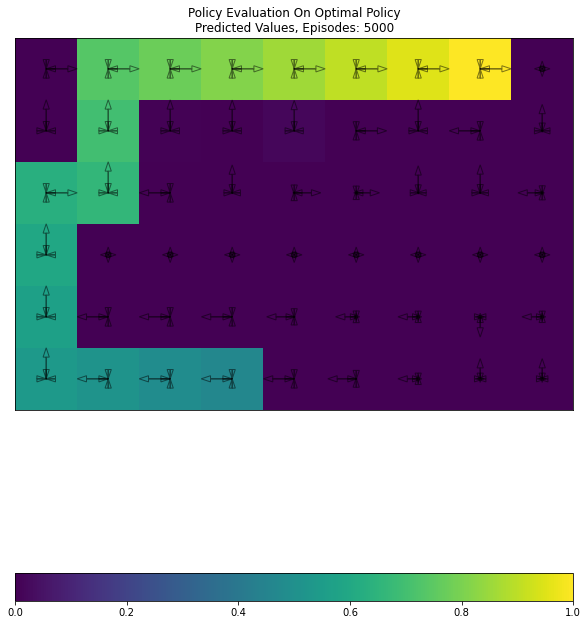

In [15]:
manager = Manager(env_info=env_info,
                  agent_info=agent_info,
                  experiment_name="Policy Evaluation On Optimal Policy")
manager.visualize(values=v, num_episodes=num_episodes)